# Edits detection rate analysis

In [ ]:
from scipy.stats import mannwhitneyu
from typing import Optional
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
import os

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [ ]:
# data locations
BASEDIR = "/Users/manuel/Desktop/wgs_crisprscas9/data"
REPORTS = os.path.join(BASEDIR, "reports")
GUIDESEQ = os.path.join(BASEDIR, "offtargets/guideseq")
CIRCLESEQ = os.path.join(BASEDIR, "offtargets/circleseq")
RESULTS = "/Users/manuel/Desktop/wgs_crisprscas9/results"
# data variables
VCALLINGTOOLS = ["mutect2", "strelka", "varscan"]
GUIDES = ["EMX1", "HEKSite4", "RNF2", "VEGFASite3"]
EXPERIMENTS = ["circleseq", "guideseq"]
CELLTYPES = ["GM12878", "K562"]
# plots variables
MMCOLORMAP = {
    0: "#030303", 
    1: "#5C5B5B", 
    2: "#6A6A6A", 
    3: "#8A8A8A", 
    4: "#A7A7A7", 
    5: "#C2C1C1", 
    6: "#D5D5D5"
}
VTYPECOLORMAP = {
    "snv": "#056EA2", 
    "deletion": "#AA861F", 
    "insertion": "#8C00A7", 
    "polyploid": "#A20505"
}
EDIT_LEN = 23
REGION_LEN = 10000
REGION_FOCUS_LEN = 100

## Edits by offtarget

In [ ]:
def plot_edits_offtargets(
    report: pd.DataFrame, guide: str, cell_type: str, exp_type: str, vtool: str
) -> None:
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    labels = sorted(list(set(report.MISMATCHES.tolist())))
    colors = ["#D85915", "#0032B6"]
    # handle empty data
    if report.empty:
        return
    counts = [
        [report[(report.MISMATCHES == mm) & (report.FLAG == "TP")].shape[0] for mm in labels],
        [report[(report.MISMATCHES == mm) & (report.FLAG == "FP")].shape[0] for mm in labels],
    ]
    x = np.arange(len(labels))
    width = 0.2
    ax.bar(x - width / 2, counts[0], width, label="True edits detected", color=colors[0])
    ax.bar(x + width / 2, counts[1], width, label="False edits detected", color=colors[1])
    ax.set_ylim(0, max(max(counts[0]), max(counts[1])) + 10)
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.set_ylabel("# Edits", size=18)
    ax.set_xlabel("Off-target mismatches", size=18)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, {"fontsize": 14})
    ax.legend(["True edits detected", "False edits detected"], prop={"size": 18})
    ax.set_title(f"{guide}-{cell_type} ({exp_type})", fontsize=20, fontweight="bold")
    outfile = f"{vtool}_{exp_type}_{cell_type}_{guide}.png"
    plt.savefig(os.path.join(RESULTS, "edits_by_offtarget", outfile), format="png")

In [ ]:
for vtool in tqdm(VCALLINGTOOLS):
    for guide in GUIDES:
        for exp_type in EXPERIMENTS:
            for cell_type in CELLTYPES:
                report = pd.read_csv(
                    os.path.join(
                        REPORTS,
                        vtool,
                        f"{vtool}_{exp_type}_{cell_type}_{guide}_onregion.tsv"
                    ),
                    sep="\t"
                )
                plot_edits_offtargets(report, guide, cell_type, exp_type, vtool)

## Allele depth supporting phenotype

In [ ]:
def plot_ad_phenotype(
    report: pd.DataFrame, guide: str, cell_type: str, exp_type: str, vtool: str
) -> None:
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    labels = [
        "True edits detected (REF)", 
        "True edits detected (ALT)",
        "False edits detected (REF)", 
        "False edits detected (ALT)",
    ]
    colors = ["#CB9400", "#0084CB", "#B200CB", "#313131"]
    edits = [
        report[report.FLAG == "TP"]["AD-TUMOR-REF"].tolist(),
        report[report.FLAG == "TP"]["AD-TUMOR-ALT"].tolist(),
        report[report.FLAG == "FP"]["AD-TUMOR-REF"].tolist(),
        report[report.FLAG == "FP"]["AD-TUMOR-ALT"].tolist(),
    ]
    for i, e in enumerate(edits):
        sns.distplot(e, hist=False, label=labels[i], color=colors[i], ax=ax)
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.set_ylabel("# Edits", size=18)
    ax.set_xlabel("Allele read depth", size=18)
    ax.legend(labels, prop={"size": 18})
    ax.set_title(f"{guide}-{cell_type} ({exp_type})", fontsize=20, fontweight="bold")
    outfile = f"{vtool}_{exp_type}_{cell_type}_{guide}.png"
    plt.savefig(os.path.join(RESULTS, "ad_by_phenotype", outfile), format="png")

In [ ]:
for vtool in tqdm(VCALLINGTOOLS):
    for guide in GUIDES:
        for exp_type in EXPERIMENTS:
            for cell_type in CELLTYPES:
                report = pd.read_csv(
                    os.path.join(
                        REPORTS,
                        vtool,
                        f"{vtool}_{exp_type}_{cell_type}_{guide}_onregion.tsv"
                    ),
                    sep="\t"
                )
                plot_ad_phenotype(report, guide, cell_type, exp_type, vtool)

## Allele depth to support editing

In [ ]:
def plot_ad_edit(
    report: pd.DataFrame, guide: str, cell_type: str, exp_type: str, vtool: str
) -> None:
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    labels = ["True edits detected", "False edits detected"]
    colors = ["#D85915", "#0032B6"]
    edits = [
        report[report.FLAG == "TP"]["AD-TUMOR-ALT"].tolist(),
        report[report.FLAG == "FP"]["AD-TUMOR-ALT"].tolist(),
    ]
    for i, e in enumerate(edits):
        sns.distplot(e, hist=False, label=labels[i], color=colors[i], ax=ax)
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.set_ylabel("Density", size=18)
    ax.set_xlabel("Allele read depth", size=18)
    ax.legend(labels, prop={"size": 18})
    ax.set_title(f"{guide}-{cell_type} ({exp_type})", fontsize=20, fontweight="bold")
    outfile = f"{vtool}_{exp_type}_{cell_type}_{guide}.png"
    plt.savefig(os.path.join(RESULTS, "edit_by_ad", outfile), format="png")

In [ ]:
for vtool in tqdm(VCALLINGTOOLS):
    for guide in GUIDES:
        for exp_type in EXPERIMENTS:
            for cell_type in CELLTYPES:
                report = pd.read_csv(
                    os.path.join(
                        REPORTS,
                        vtool,
                        f"{vtool}_{exp_type}_{cell_type}_{guide}_onregion.tsv"
                    ),
                    sep="\t"
                )
                plot_ad_edit(report, guide, cell_type, exp_type, vtool)

## Edits type by allele depth

In [141]:
def plot_ad_cumsum(
    report: pd.DataFrame, guide: str, cell_type: str, exp_type: str, vtool: str
) -> None:
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    labels = ["True edits detected", "False edits detected"]
    colors = ["#D85915", "#0032B6"]
    allele_depth = list(range(1010))
    edits = [
        [
            report[(report.FLAG == "TP") & (report["AD-TUMOR-ALT"] < ad)].shape[0]
            for ad in allele_depth
        ],
        [
            report[(report.FLAG == "FP") & (report["AD-TUMOR-ALT"] > ad)].shape[0]
            for ad in allele_depth
        ],
    ]
    ax.plot(allele_depth, edits[0], c=colors[0], label=labels[0])
    ax.plot(allele_depth, edits[1], c=colors[1], label=labels[1])
    ax.set_ylim(0, max(max(edits[0]), max(edits[1])) + 10)
    ax.set_xlim(-1, 1010)
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.set_ylabel("# Edits", size=18)
    ax.set_xlabel("Alternate allele read depth", size=18)
    ax.legend(labels, prop={"size": 18})
    ax.set_title(f"{guide}-{cell_type} ({exp_type})", fontsize=20, fontweight="bold")
    outfile = f"{vtool}_{exp_type}_{cell_type}_{guide}.png"
    plt.savefig(os.path.join(RESULTS, "edits_type_by_ad", outfile), format="png")

100%|██████████| 3/3 [11:52<00:00, 237.38s/it]


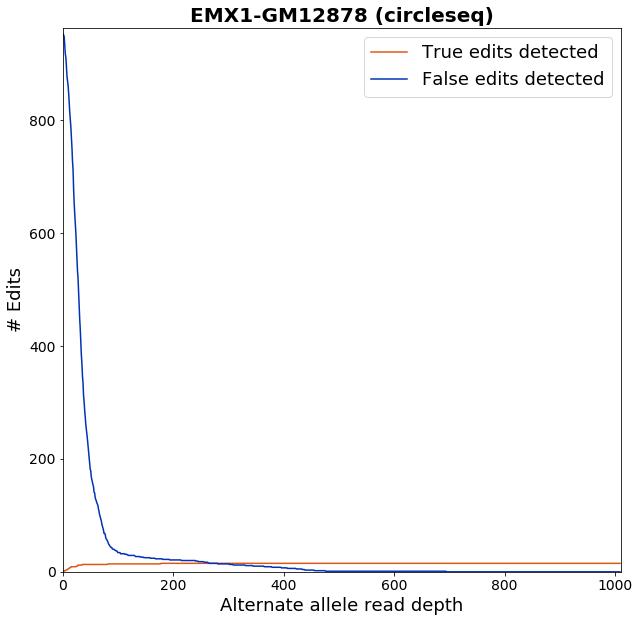

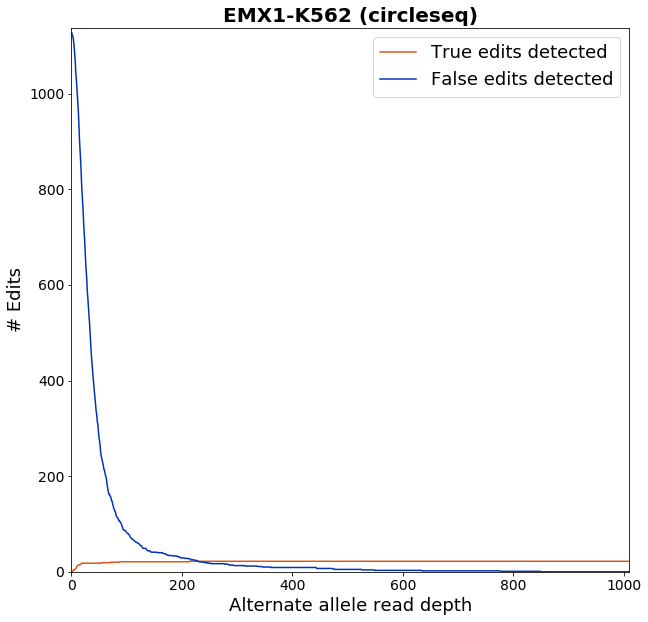

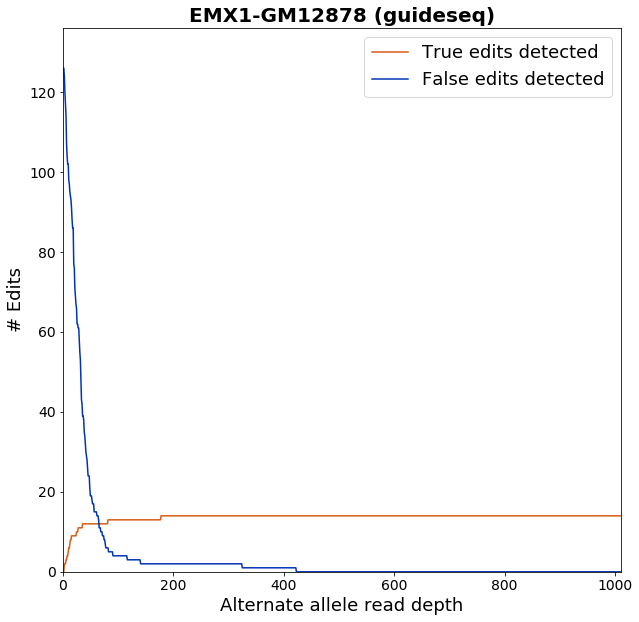

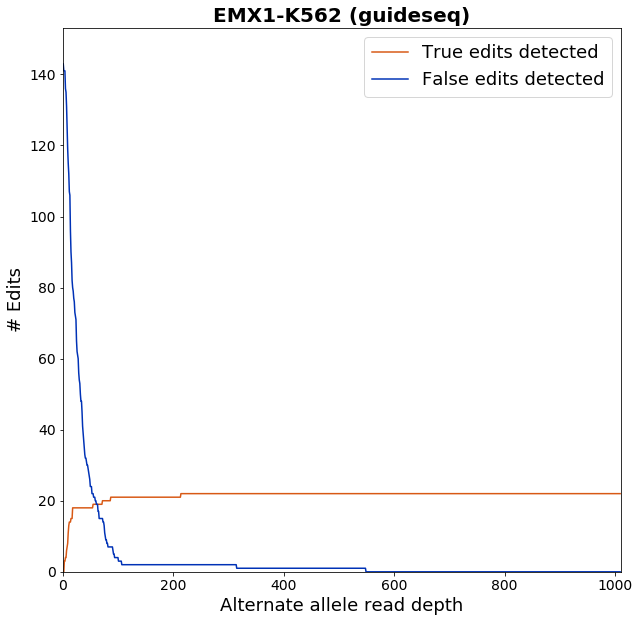

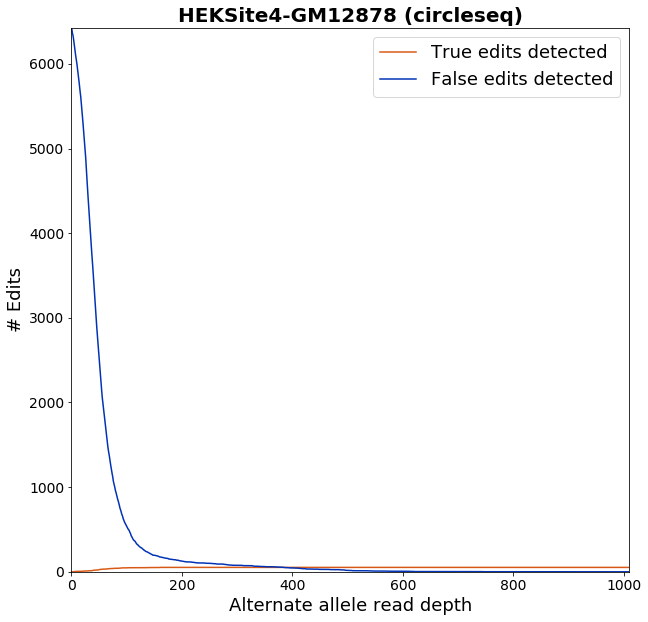

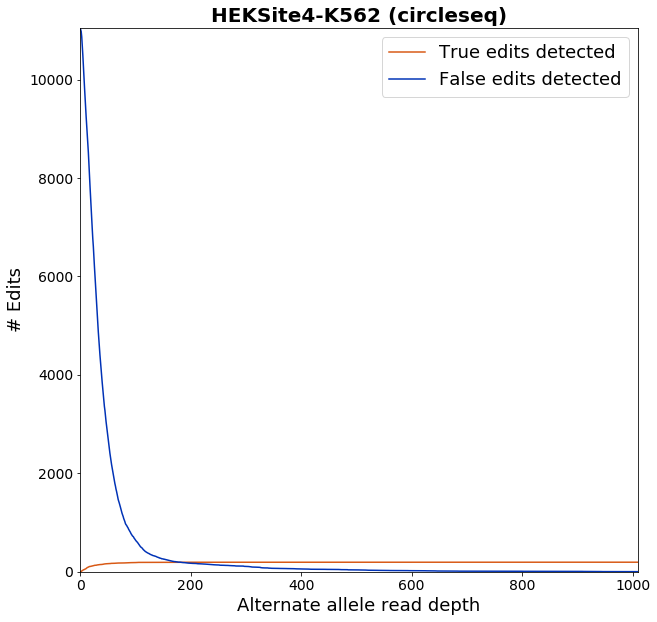

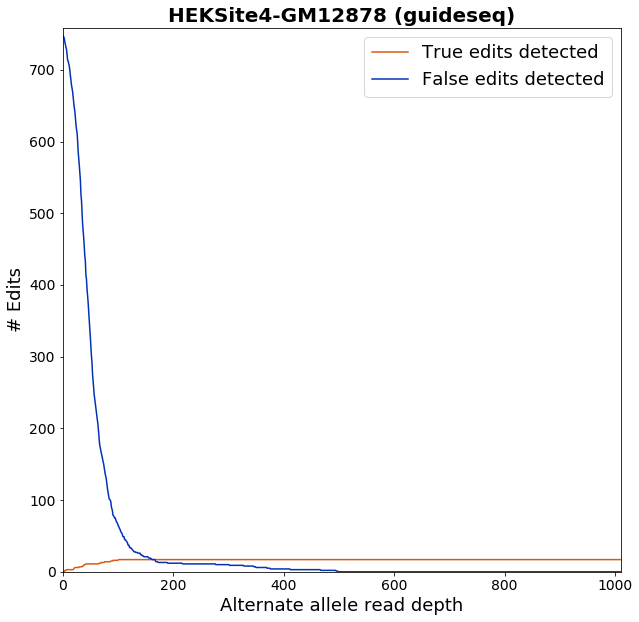

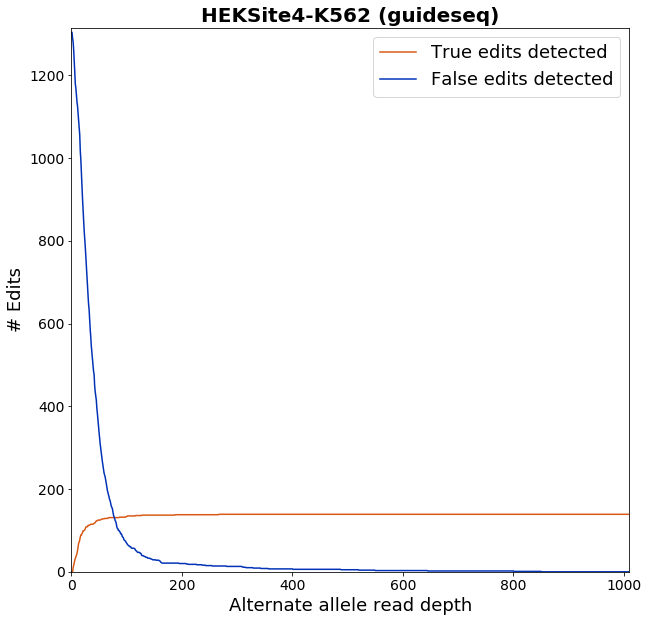

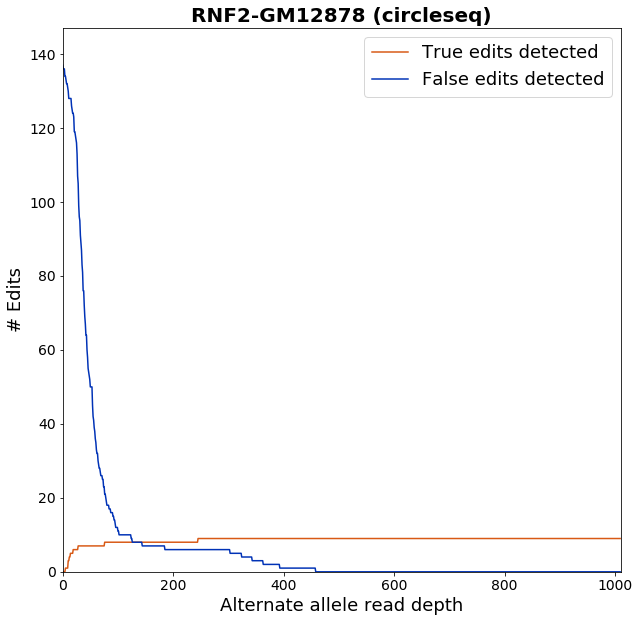

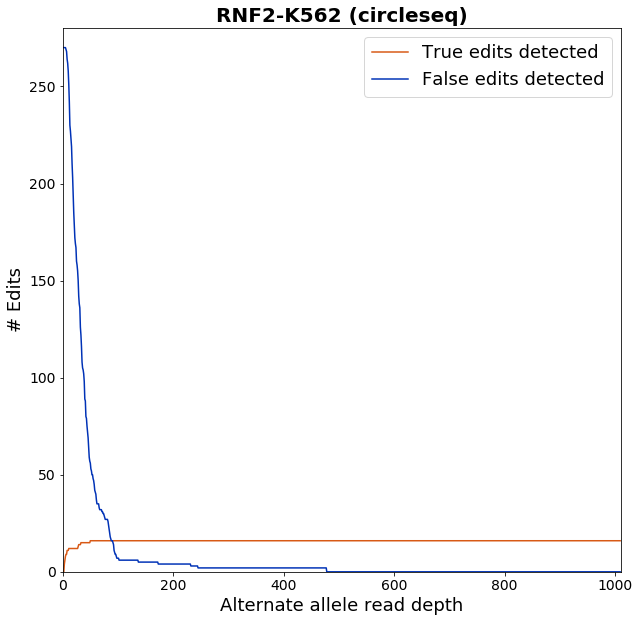

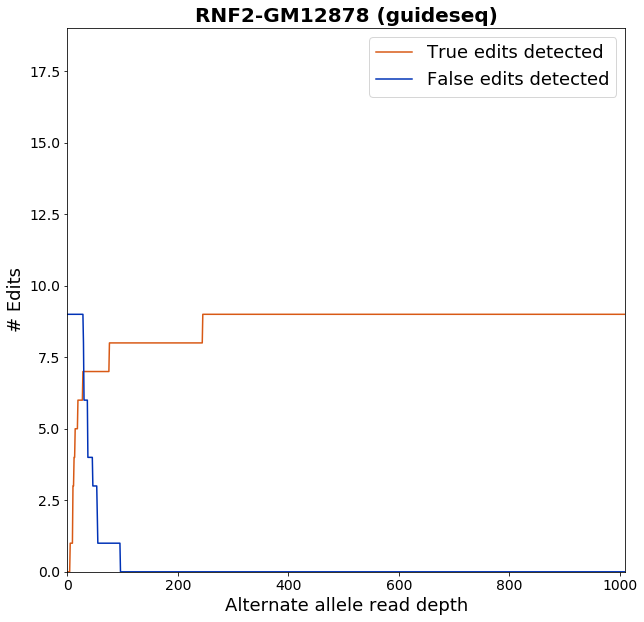

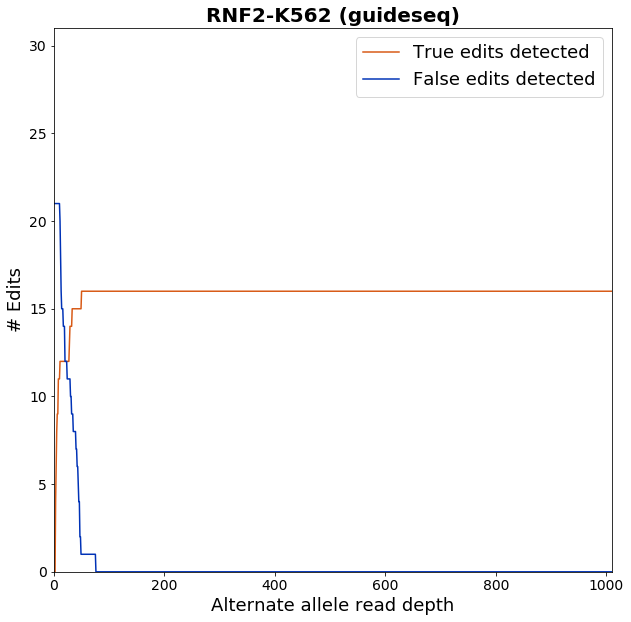

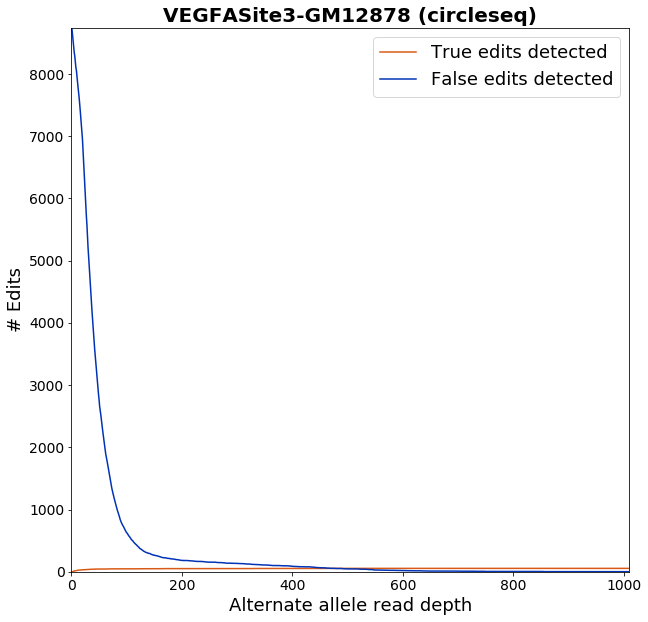

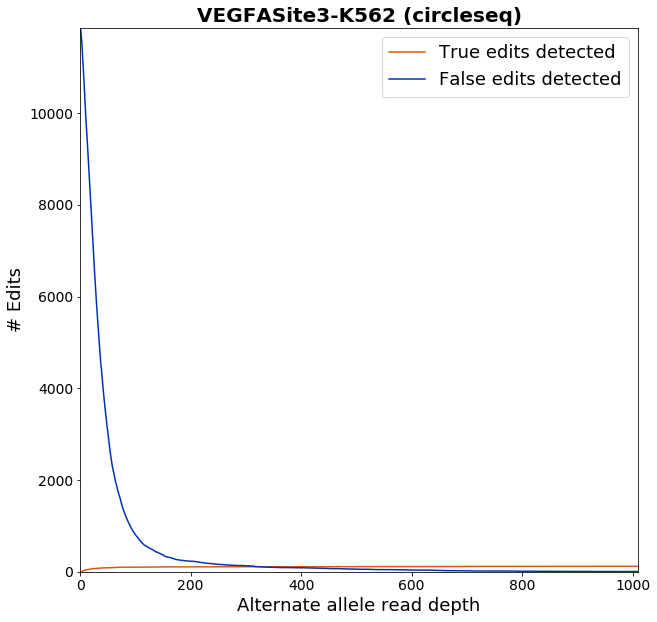

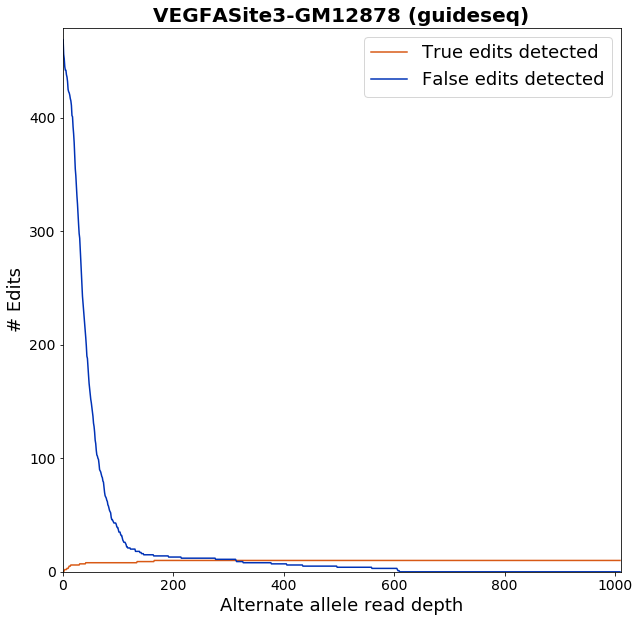

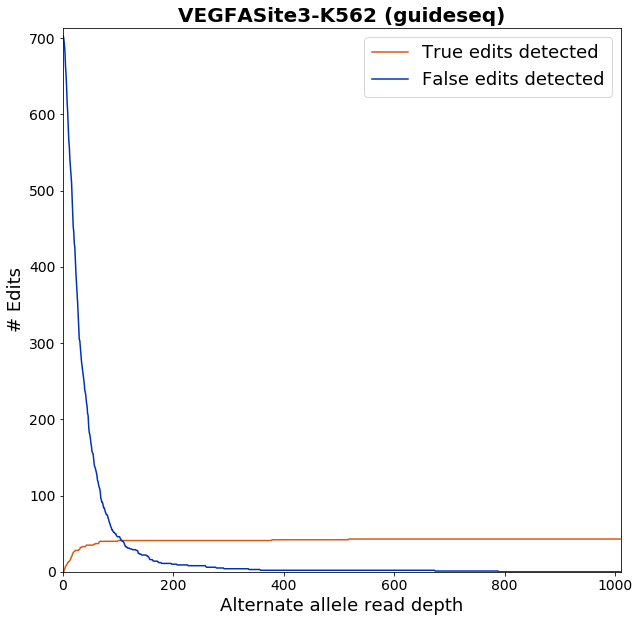

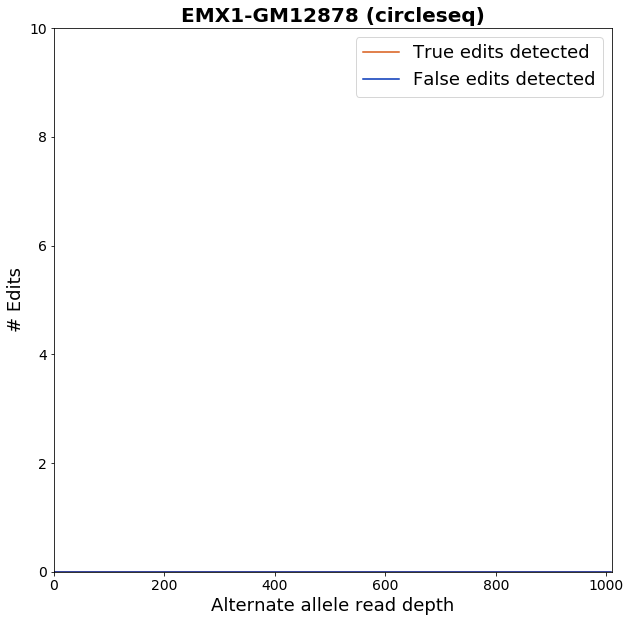

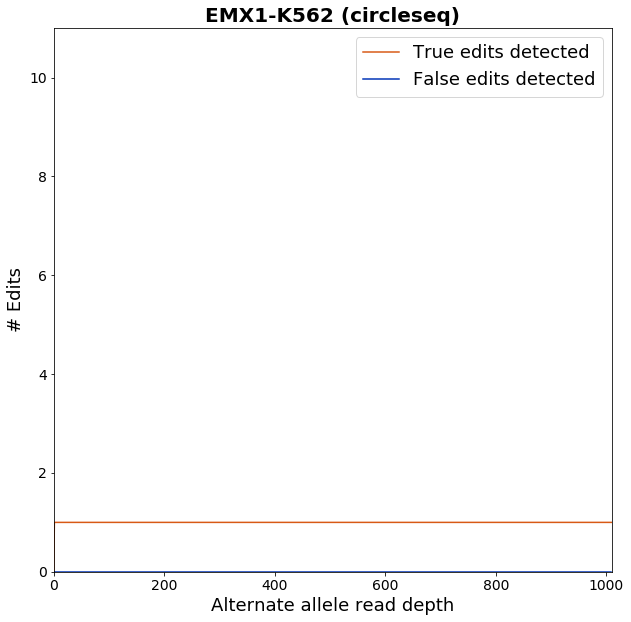

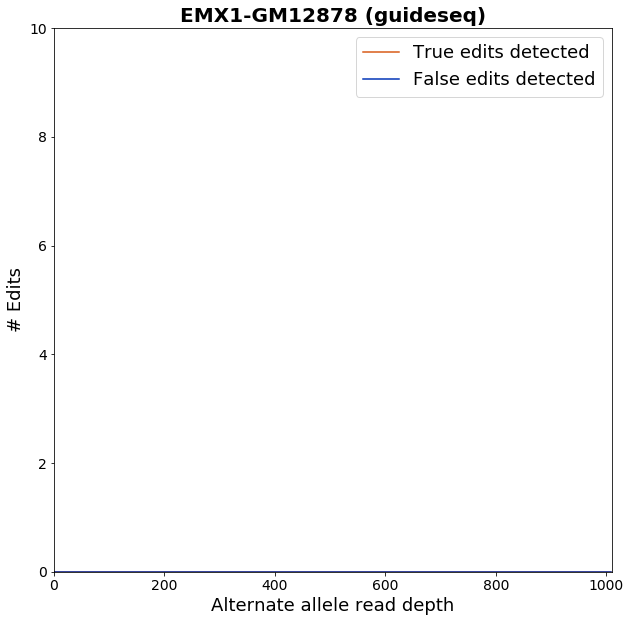

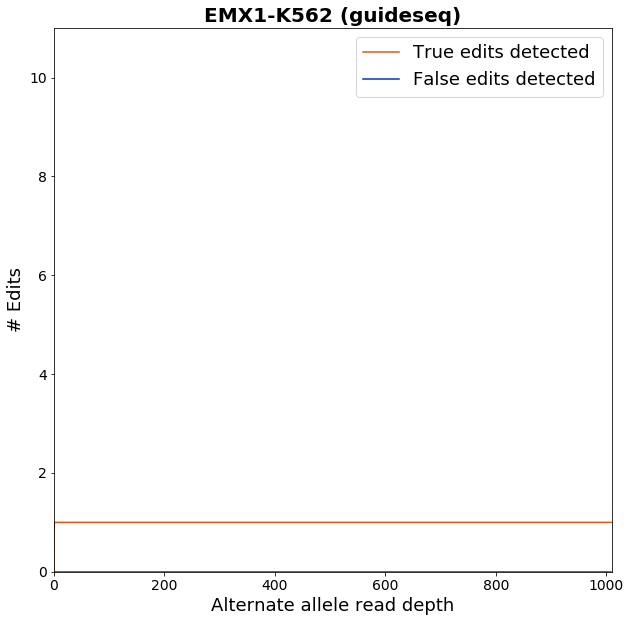

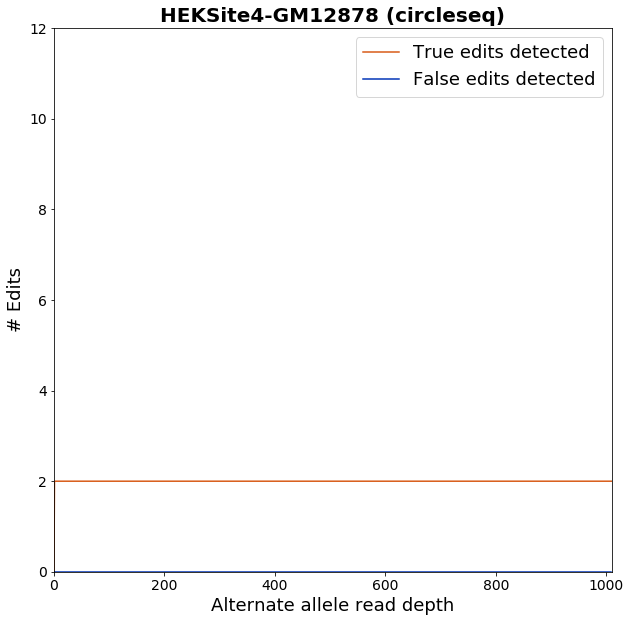

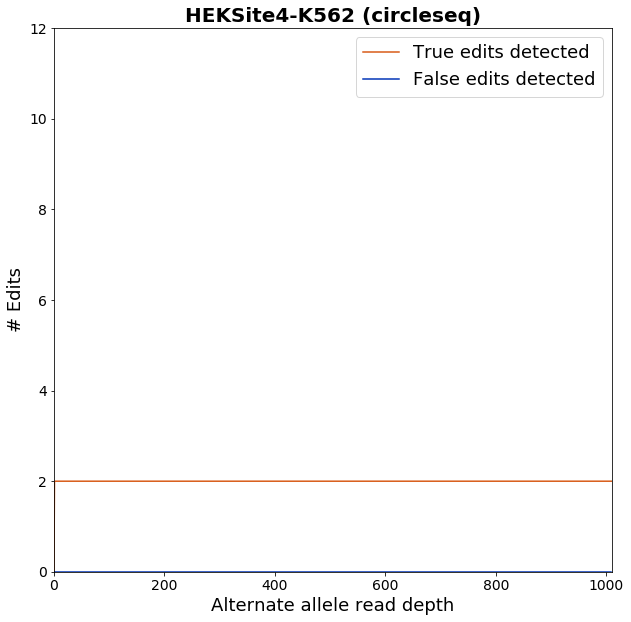

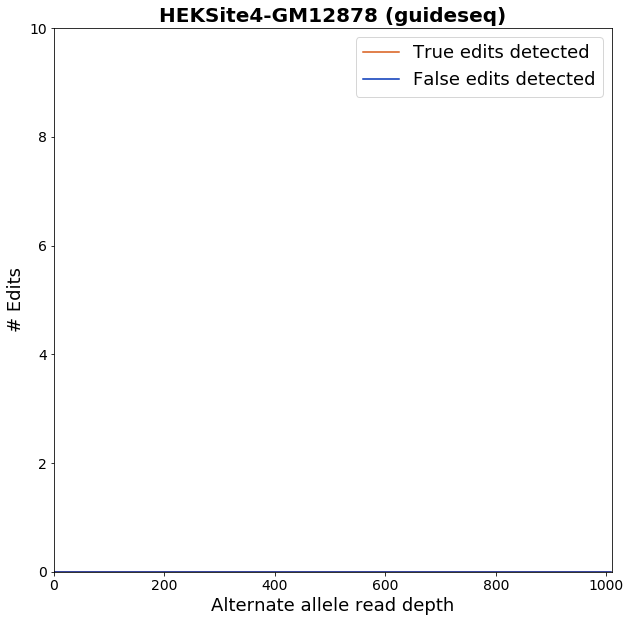

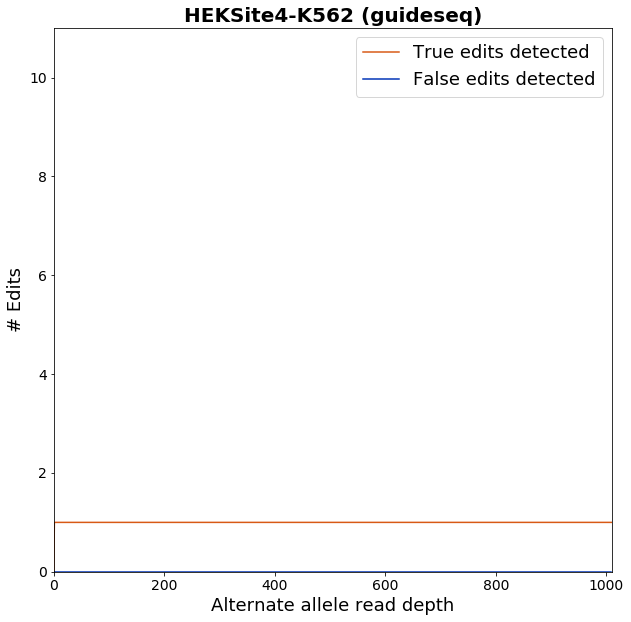

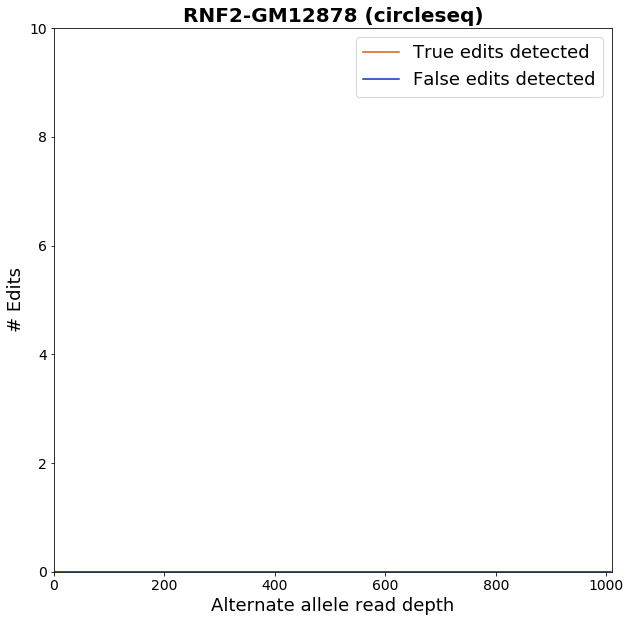

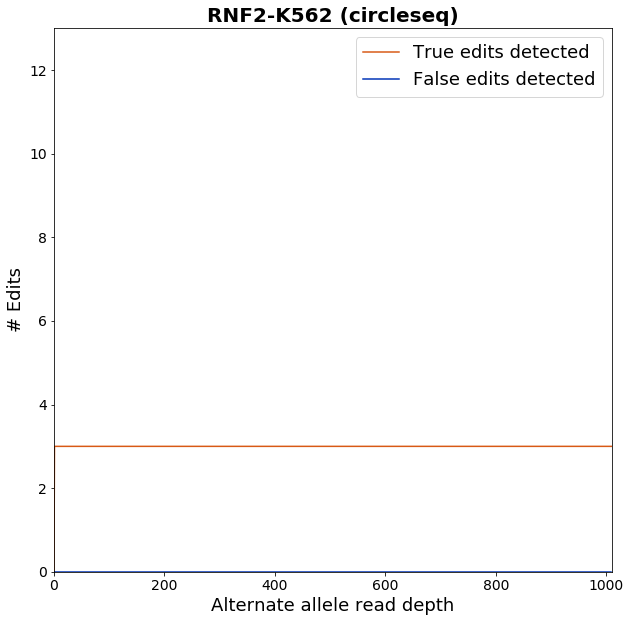

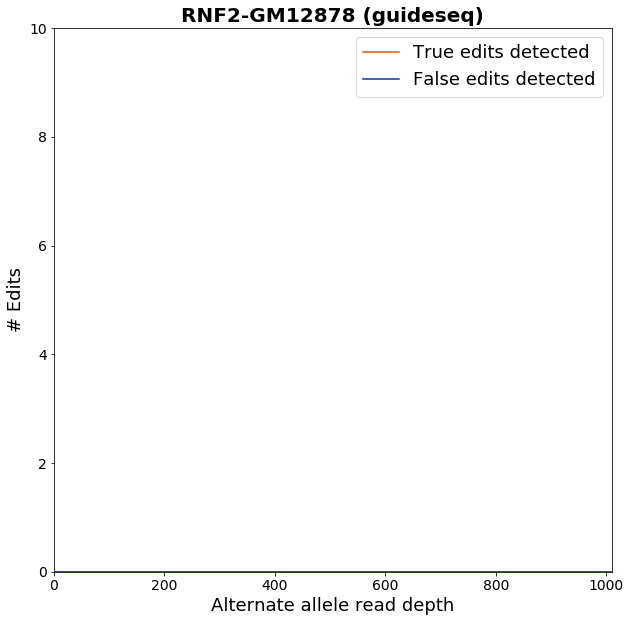

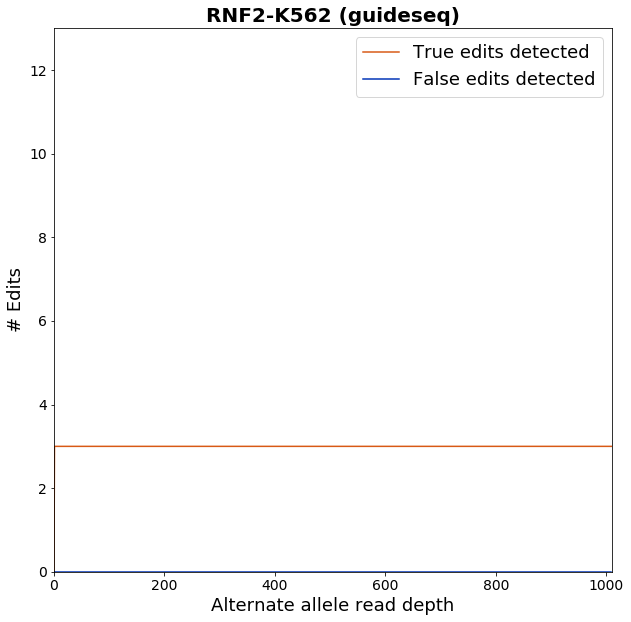

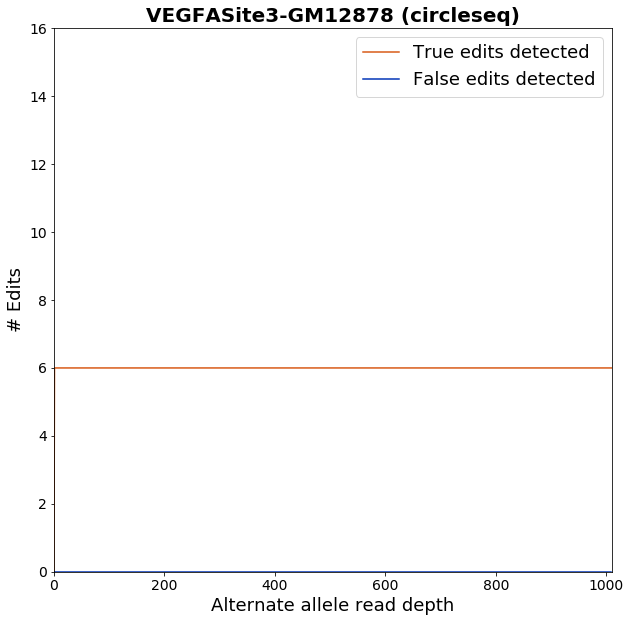

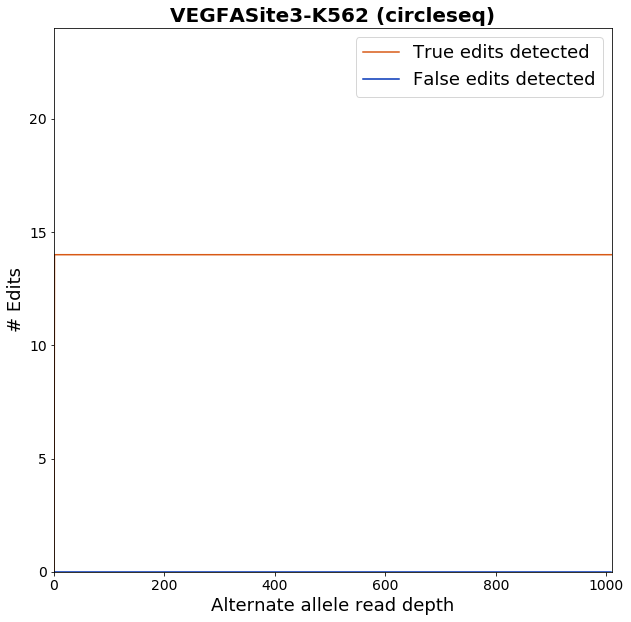

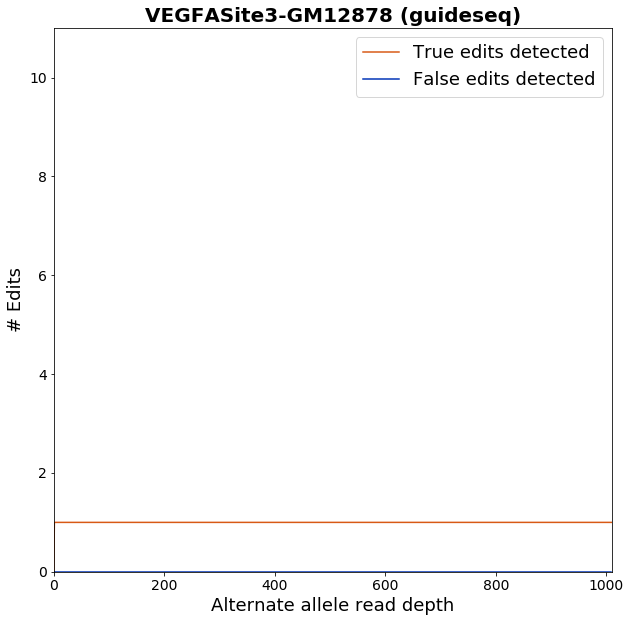

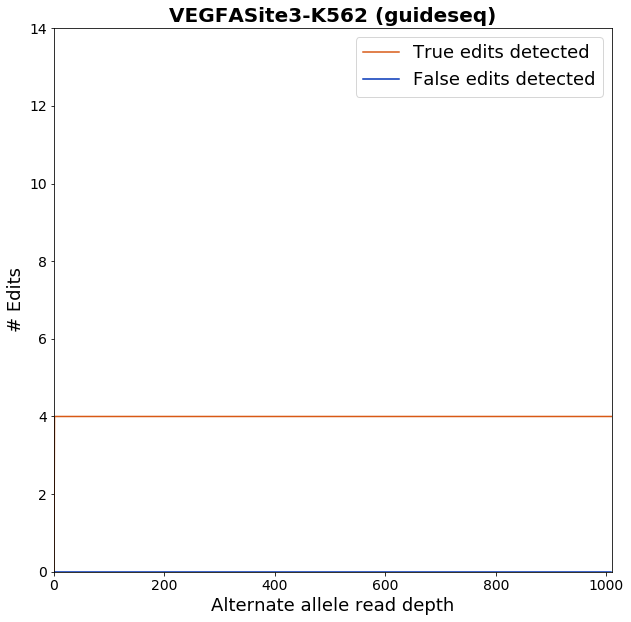

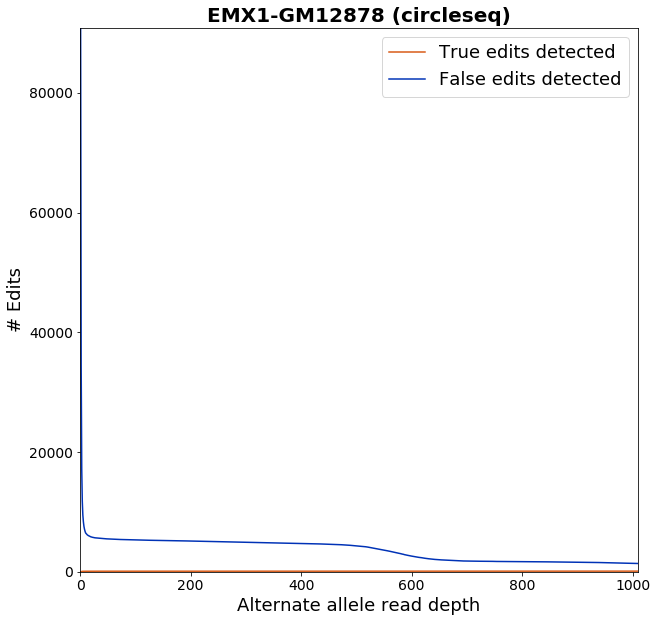

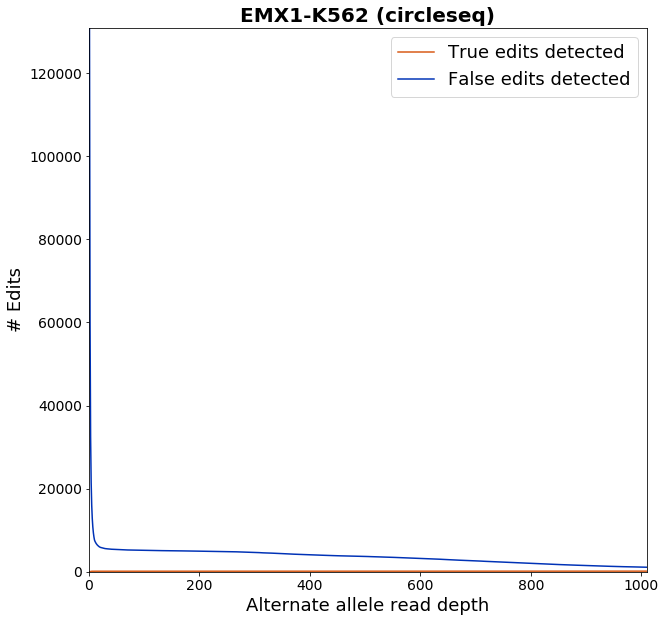

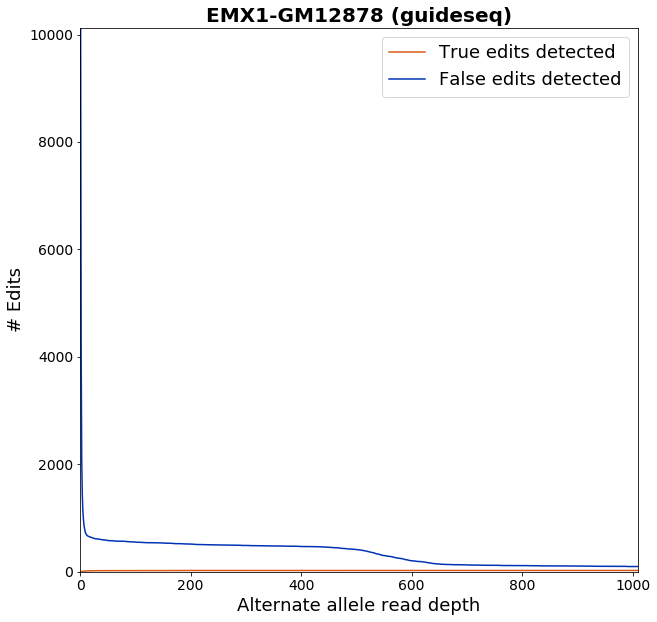

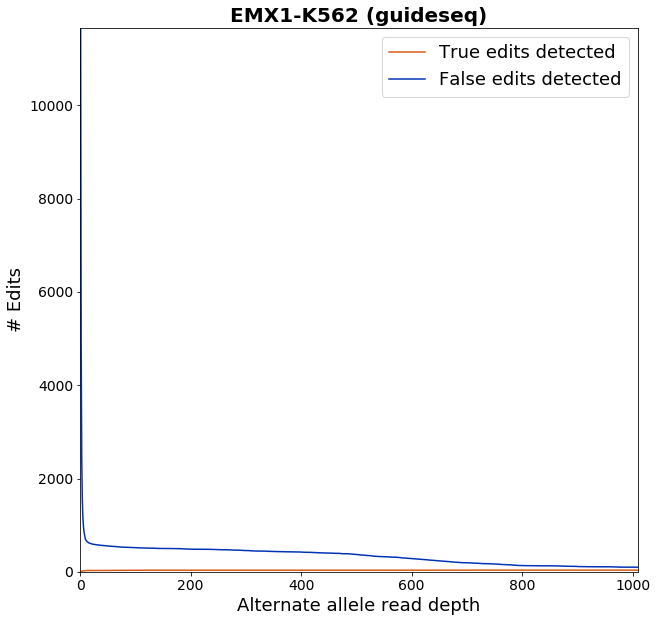

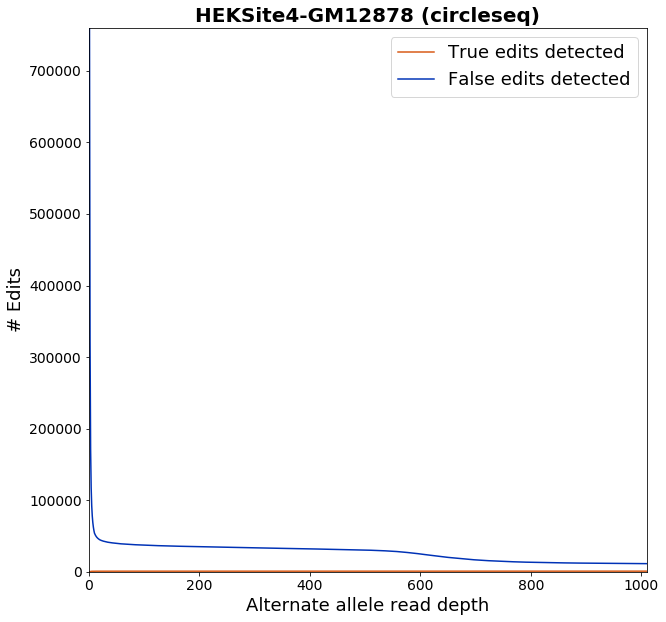

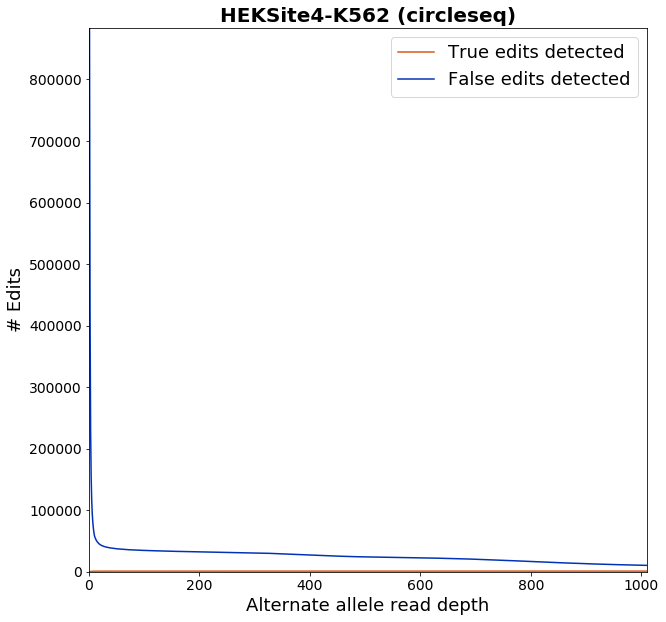

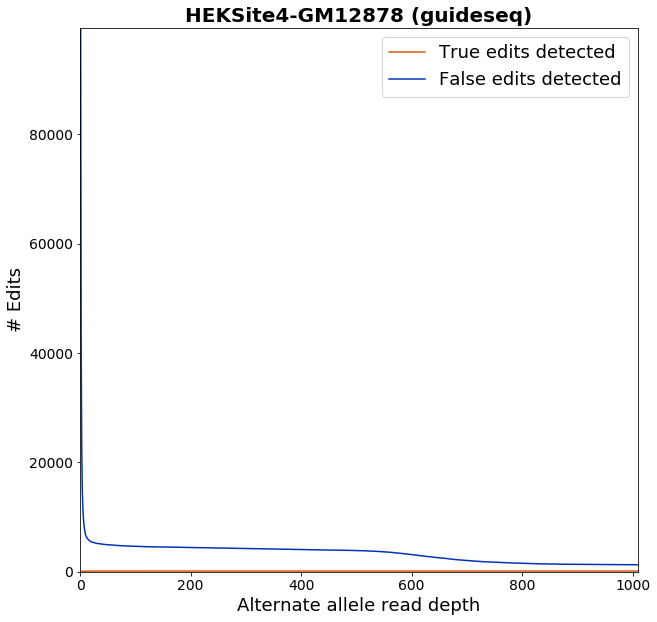

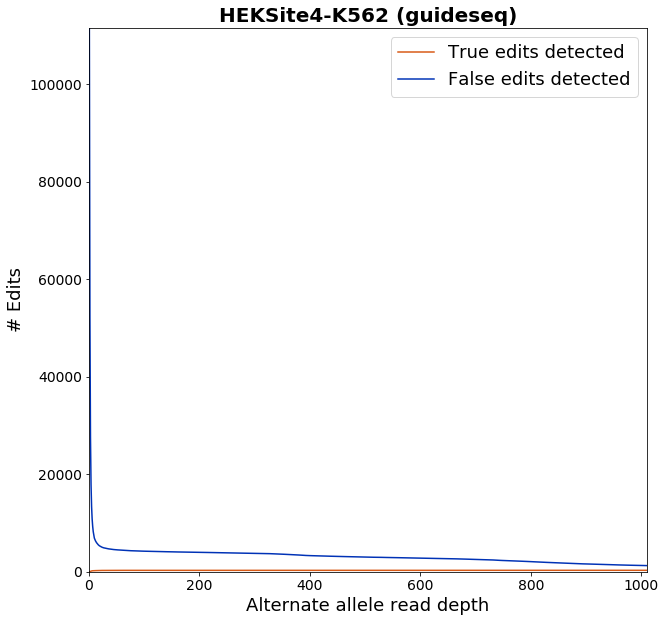

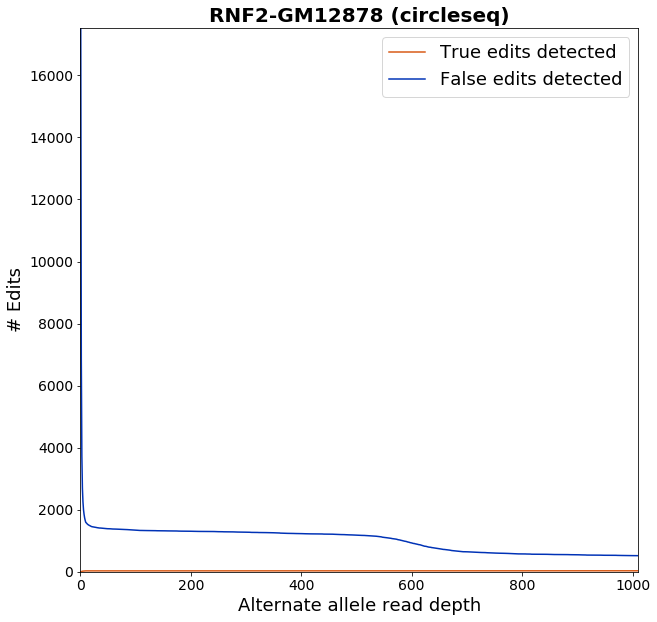

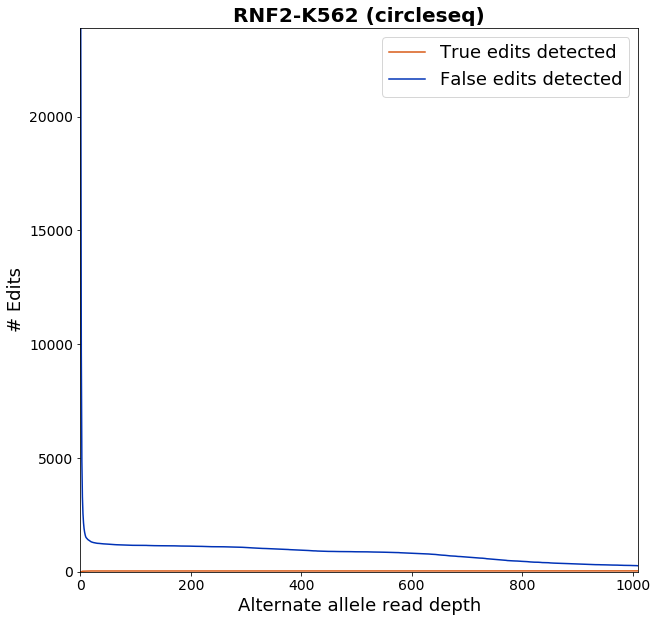

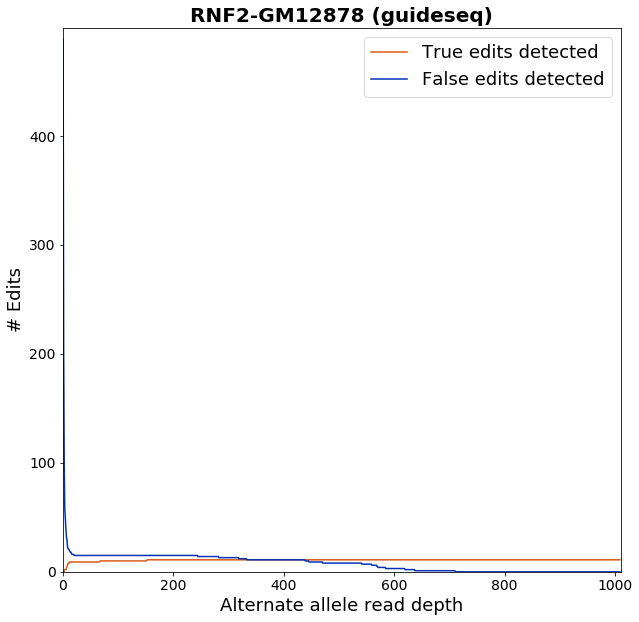

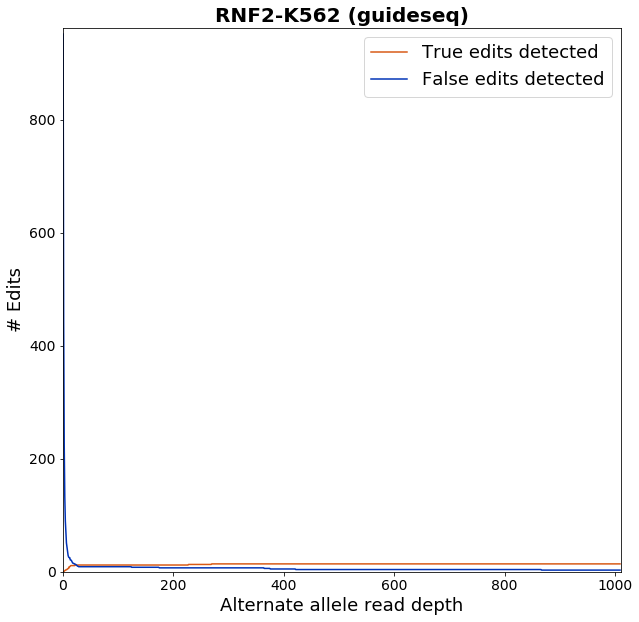

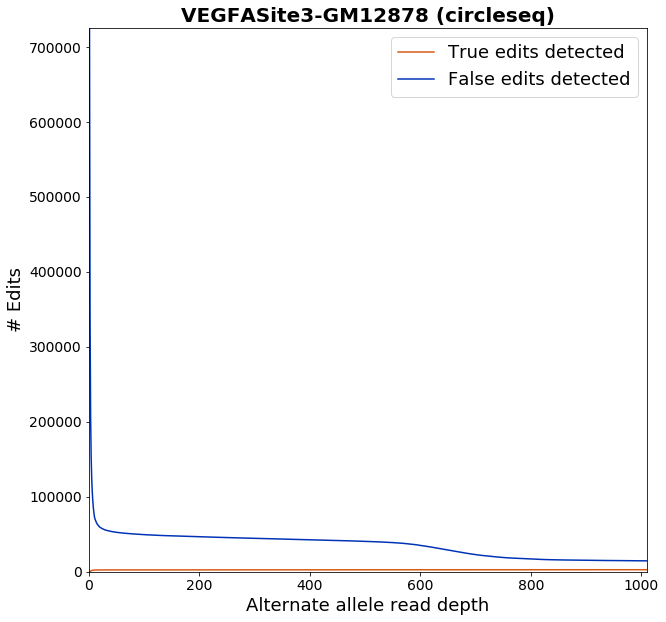

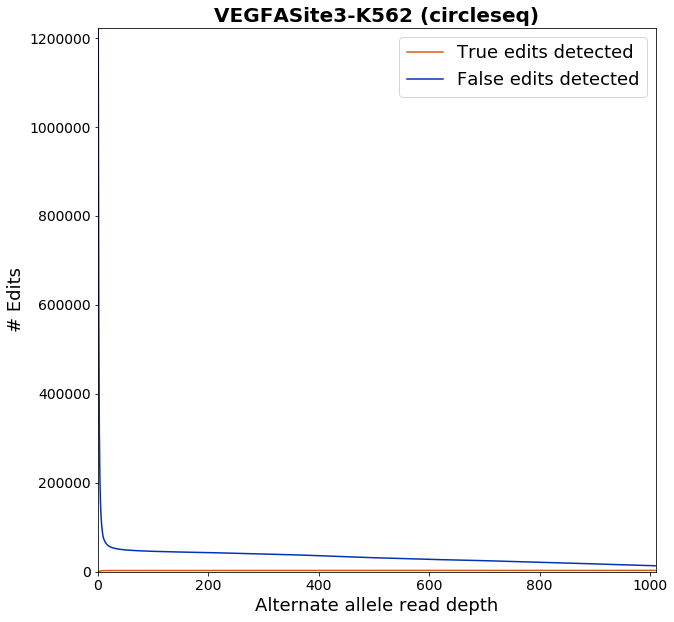

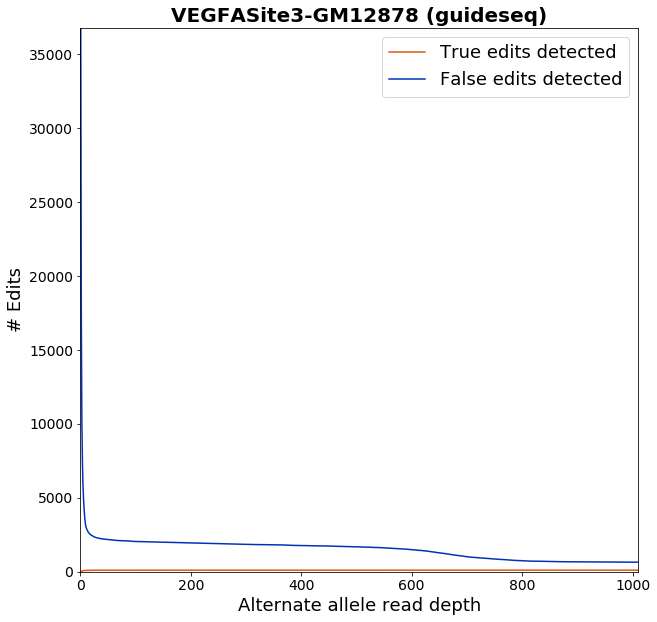

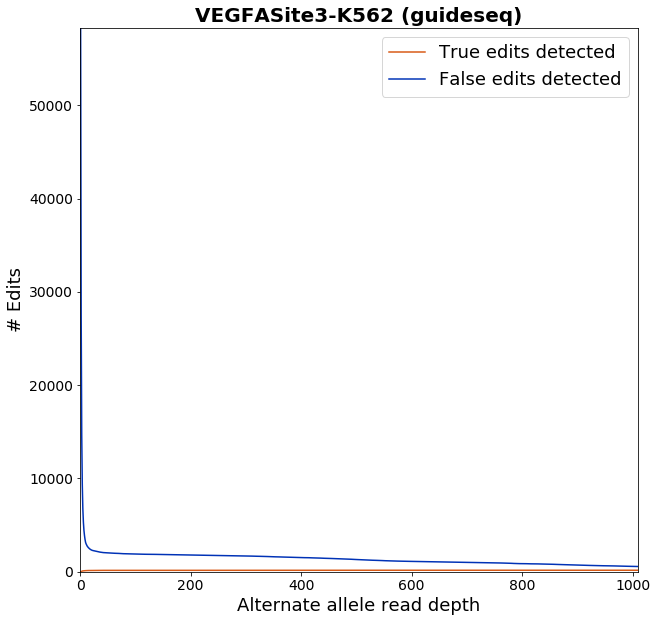

In [140]:
for vtool in tqdm(VCALLINGTOOLS):
    for guide in GUIDES:
        for exp_type in EXPERIMENTS:
            for cell_type in CELLTYPES:
                report = pd.read_csv(
                    os.path.join(
                        REPORTS,
                        vtool,
                        f"{vtool}_{exp_type}_{cell_type}_{guide}_onregion.tsv"
                    ),
                    sep="\t"
                )
                plot_ad_cumsum(report, guide, cell_type, exp_type, vtool)